# Exercise #5a - REINFORCE

<img src="figures/reinforce.png" width="50%" align="right"/>

In this exercise we will implement the Policy Gradient algorithm REINFORCE, of which the pseudo-code is depicted on the right.

This algorithm trains on complete trajectories of an episode to train an estimator that predicts the policy (i.e. action probabilities).

First include the basic necesities we are fimiliar with now.

In [1]:
import gymnasium
import numpy as np
from utils import run_environment, evaluate

In this exercise we will use the already demonstrated `LunarLander` environment.

In [2]:
env = gymnasium.make('LunarLander-v2', render_mode='rgb_array')

## Policy estimator

For estimating the policy we will use a neural network that predicts action probabilities fpr a given observation. There is not enough time to implement this from scratch in this training, so we will use a given implementation. The class `PolicyEstimator` from the module ['estimator.py'](estimator.py) is implemented in a similar fashion as the `ActionValueEstimator` that we have used before.

It has two major functions:
- `predict(observation)`: Returns an array of probabilities for each action.
- `train(observations, actions, returns)`: Trains the estimator on the given observations. For each observation a corresponding action and a return must be provided that specify which action was taken and what the return of that action was. The probabilities for actions with high returns will be increased more than actions with low returns.

If you are interested and if you have time then you could take a look at the [implementation](estimator.py) of this estimator.

Let's import it and create a new instance.

In [3]:
from estimator import PolicyEstimator

policy_estimator = PolicyEstimator(env)

Using cuda device


If we give it an observation, it should return 4 probabilities for each action that can be taken in this environment.

In [4]:
observation, _ = env.reset()
policy_estimator.predict(observation)

array([0.28317213, 0.23882769, 0.27440754, 0.20359263], dtype=float32)

Because this policy estimator is newly created, i.e. untrained, it should return a more or less uniformly distributed policy, where all actions probabilities are more or less equal. In this case all probabilities should be around 0.25.

## Select action

Instead of the $\epsilon$-greedy policy that we have used before, we are now going to select an action randomly according to the distribution given by the policy estimator. So, actions with a higher probability will be selected more often.

This selection can be implemented with the [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) function. Its first parameter should be the number of actions to choose from (you can use `env.action_space.n`), and parameter `p` should be set to the probabilities of each action.

Use the `policy_estimator` to predict action probabilities for the given `observation` using the `predict` function.

In [5]:
def random_policy(observation):
    global env, policy_estimator
    #### START CODE ####
    action_probs = policy_estimator.predict(observation)
    action = np.random.choice(len(action_probs), p=action_probs)
    #### END CODE ####
    return action

Let's see if it works. If you run the following cell, you should get a single integer between 0 and 4 as a result. Re-run the cell to check if it is indeed randomly chosen.

In [6]:
observation, _ = env.reset()
action = random_policy(observation)
assert 0 <= action < 4
action

0

## Expected returns

Once the policy estimator is trained it should represent a policy that maximizes the expected return. So, for training we need to know the return $G_t$ at each timestep $t$, which is defined as:

$$\begin{align}
G_t &= R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} \cdots \\
    &= R_{t+1} + \gamma G_{t+1}
\end{align}$$

We have the rewards $R_t$ gathered during the episode, so we can easily compute the $G_t$ for each step by traversing the rewards backwards. We start at $t = T$ (the terminal state) and go backward to $t = 0$. Remember, $G_T$ is 0, i.e. the terminal state has no expected return.

This process is called discounting the rewards. You have to implement this in the following `discount` function. Note: in python you can simply reverse a list using the built-in function `reversed(a)` and you can insert an item at the start of a list with `a.insert(0, v)`.

The extra dimension that is added is to make the array shape correct for usage in later exercises.

In [7]:
def discount(rewards, gamma):
    expected_returns = []

    ### START CODE ###
    # Initialize G_t to 0 for t = T
    g_t = 0

    # Reverse through rewards
    for r in reversed(rewards):
        # Compute new G_t using current reward
        g_t = r + gamma * g_t
        # Insert reward in front of expected_returns
        expected_returns.insert(0, g_t)

    ### END CODE ###

    # Convert to float32 NumPy array
    expected_returns = np.array(expected_returns, dtype=np.float32)

    # Add additional dimension
    return np.expand_dims(expected_returns, axis=-1)

Let's see if it works by running this small unit test.

In [8]:
rewards = np.array([0, 1, 2, 3, 0, -3])
discount(rewards, 0.9)

array([[ 2.93553],
       [ 3.2617 ],
       [ 2.513  ],
       [ 0.57   ],
       [-2.7    ],
       [-3.     ]], dtype=float32)

The output should be exactly:

    array([[ 2.93553],
           [ 3.2617 ],
           [ 2.513  ],
           [ 0.57   ],
           [-2.7    ],
           [-3.     ]], dtype=float32)

If this is not the case (besides floating point rounding errors), then check your implementation.

During the remainder of this exercise we will use the same discount factor, called `gamma`, with a value of 0.99.

In [9]:
gamma = 0.99

## Training steps

Discounting rewards can only be done at the end of an episode, when the terminal state has been reached. We will define an `on_episode_end` callback function for our `run_environment` helper function to train the estimator.

In this callback function you first have to discount the rewards to get the returns. Then we can hand all the required information to the `train` function of the `policy_estimator` to train it one step (see above for the function specification).

In [10]:
def on_episode_end(episode, observations, actions, rewards, length, score):
    #### START CODE ####
    # Discount rewards
    returns = discount(rewards, gamma)
    # Train policy estimator
    policy_estimator.train(observations, actions, returns)
    #### END CODE ####

### Training

That's all we need. What is left is to run a number of episodes to train the policy estimator. Simply execute the following cell and take a break. It could take a few minutes to finish.

In [11]:
run_environment(env, 500, random_policy, on_episode_end=on_episode_end)

policy_estimator.save_weights('lunar-reinforce.pth')

100%|██████████| 500/500 [02:44<00:00,  3.04it/s, avg_length=467.2, avg_score=-91.2] 


## Evaluation

During evaluation we no longer want to explore, but only exploit. So, instead of choosing an action randomly we want to take the action with the highest probability. Like in the DQN algorithm we can simply use the [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function for this.

Finish the following policy function.

In [12]:
def greedy_policy(observation):
    global policy_estimator
    #### START CODE ####
    # Predict action probabilities with policy estimator
    action_probs = policy_estimator.predict(observation)
    # Select action with highest probability
    action = np.argmax(action_probs)
    #### END CODE ####
    return action

Let's first see how an untrained estimator performs.

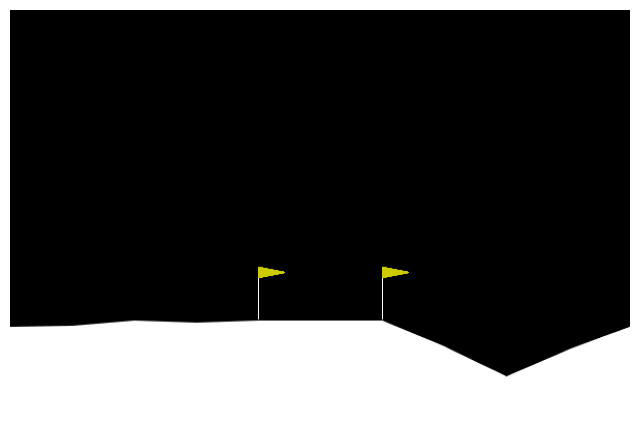

Episode length: 130, return: -738.0870524107011
Evaluation: length 130, score -738.0870524107011


In [13]:
policy_estimator = PolicyEstimator(env)
eval_length, eval_score = evaluate(env, greedy_policy)
print(f'Evaluation: length {eval_length}, score {eval_score}')

That's really bad. It hardly does anything to prevent crashing instantly.

And, now look at how it performs after 500 steps.

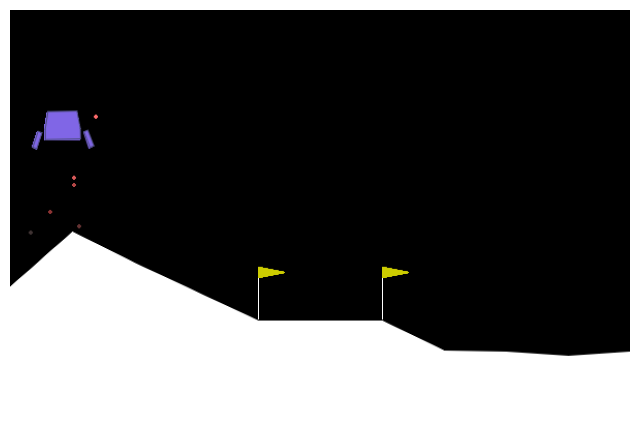

Episode length: 1000, return: -106.5422927939738
Evaluation: length 1000, score -106.5422927939738


In [14]:
policy_estimator.load_weights('lunar-reinforce.pth')
eval_length, eval_score = evaluate(env, greedy_policy)
print(f'Evaluation: length {eval_length}, score {eval_score}')

That is a lot better, it no longer crashes immediately, but still not optimal. It now hovers for a long time without landing.

To get a lot better performance we have to train it for a lot longer. This is how it performs after being trained for 5000 episodes, which took about 1 hour and 20 minutes.

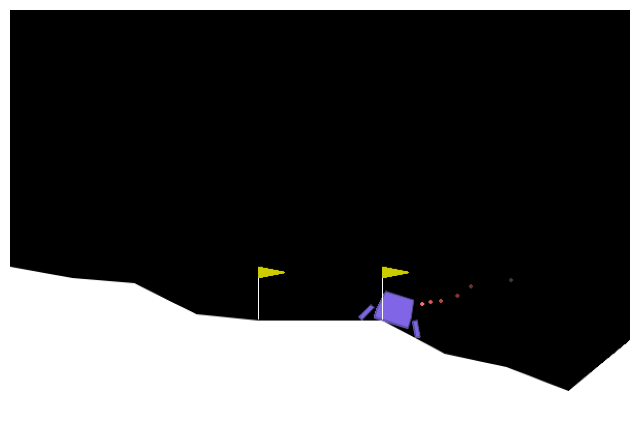

Episode length: 129, return: -8.539107453345935
Evaluation: length 129, score -8.539107453345935


In [15]:
policy_estimator.load_weights('trained/lunar-reinforce.pth')
eval_length, eval_score = evaluate(env, greedy_policy)
print(f'Evaluation: length {eval_length}, score {eval_score}')

## Conclusion

This is all that was needed to train using the REINFORCE algorithm. It is very simple, but it needs a lot of training to converge to an optimal solution.

This algorithm, however, is the basis for a lot more advanced (and state-of-the-art) algorithms. Let's take a look at those.